# Proyecto Sprint 14 

## Introducción
### Objetivo del proyecto

Construir varios modelos de regresión para predecir el precio de coches usados a su vez evaluar calidad (RMSE), tiempo de entrenamiento y velocidad de predicción.


### Contexto del negocio (Rusty Bargain)

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:

- La calidad de la predicción
- La velocidad de la predicción
- El tiempo requerido para el entrenamiento

## Descripción de los datos
### Estructura del dataset

In [46]:
# Carga de librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
import lightgbm as lgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<div style="color: black ; background-color: LightSeaGreen">
Se cargan los datos y se hace un analisis exploratorio, vemos las primeras filas para familiarizarnos con las columnas disponibles asi como el tipo de datos que se manejan.
    
Estructura de los datasets:
354369  y existen valores ausente que más adelante veré como manejarlas.

Tipos de datos:
int y object

### Analisis de columnas (valores nulos, tipos de datos)

| Columna             | ¿Útil? | Motivo                                                                 |
|---------------------|--------|------------------------------------------------------------------------|
| `DateCrawled`       |  No  | Solo indica cuándo se descargó el perfil; no influye en el precio.     |
| **`Price`**             | **Sí**  | **Es la variable objetivo que queremos predecir.**                         |
| `VehicleType`       | Sí  | Tipo de carrocería.                |
| `RegistrationYear`  | Sí  | Año de matriculación: coches más nuevos suelen costar más.             |
| `Gearbox`           | Sí  | Transmisión automática o manual puede afectar el valor.                |
| `Power`             | Sí  | Potencia del motor (CV).                               |
| `Model`             | Sí  | El modelo del coche (dentro de la marca).                  |
| `Mileage`           | Sí  | Kilometraje. Cuanto más recorrido, menor valor.                        |
| `RegistrationMonth` | No | Puede ser útil, pero en general aporta poco. |
| `FuelType`          | Sí  | Gasolina, diésel, etc. Importa para el valor.                          |
| `Brand`             | Sí  | Marca del coche.                        |
| `NotRepaired`       | Sí  | Si ha sido reparado o no afecta el precio directamente.                |
| `DateCreated`       | No  | Fecha de publicación del anuncio, no afecta directamente.               |
| `NumberOfPictures`  | No  | Siempre vale 0 en este dataset.                                        |
| `PostalCode`        | No  | Solo indica zona geográfica del anuncio.              |
| `LastSeen`          | No  | Solo indica cuándo se vio por última vez el anuncio.                   |


## Preparación de los datos
### Limpieza de columnas irrelevantes

In [6]:
# Elimine columnas irrelevantes para la predicción del precio
columns_to_drop = [
    'DateCrawled',
    'RegistrationMonth',  # Se consideró poco relevante
    'DateCreated',
    'NumberOfPictures',
    'PostalCode',
    'LastSeen'
]

df.drop(columns=columns_to_drop, inplace=True)

### Tratamiento de valores ausentes

In [7]:
df.isnull().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Mileage                 0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

In [8]:
cols_with_na = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
df[cols_with_na] = df[cols_with_na].fillna('missing')

<div style="color: black ; background-color: LightSeaGreen">
Decido eliminar esas columnas porque  no considero que su información sea relevante para el analisis ni para los pasos posteriores como entrenamiento y predicciones, ademas veo cuantos valores nulos hay y en que tipo de columnas para despues rellenar con 'missing' las columnas categoricas ya que más adelante los modelos podrian tener problema siendo estas categoricas.


In [9]:
df.info()
# Verificación de las columnas restantes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Mileage           354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### División del conjunto de datos en entrenamiento y validación

- X → todas las columnas excepto 'Price' (estas son las features o variables independientes)
- y → la columna 'Price' (es la target, lo que quiero predecir)

In [16]:
# Separar variables predictoras (features) y variable objetivo (target)
target = df['Price']
features = df.drop(columns='Price')

In [17]:
RS = 12345  # Valor para random_state
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=RS)

## Selección y entrenamiento de modelos

### Regresión Lineal - Prueba de cordura

In [18]:
# Columnas categóricas
cat_features = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'NotRepaired'
]

In [19]:
# Transformador que aplica OneHot solo a esas columnas.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'  # Deja las columnas numéricas como están
)

# Modelo de regresión
model_lr = make_pipeline(preprocessor, LinearRegression())
# Entrenamiento
%time model_lr.fit(features_train, target_train)
# Predicción
%time preds_lr = model_lr.predict(features_valid)
# Evaluación
print('\n')
rmse_lr = np.sqrt(mean_squared_error(target_valid, preds_lr))
print("RMSE - Regresión lineal:", rmse_lr)

CPU times: user 414 ms, sys: 228 ms, total: 642 ms
Wall time: 649 ms
CPU times: user 84.9 ms, sys: 53.2 ms, total: 138 ms
Wall time: 139 ms


RMSE - Regresión lineal: 3376.935622980557


<div style="color: black ; background-color: LightSeaGreen">
La regresión lineal es muy rápida para entrenar y predecir pero considero que la calidad de la predicción como primer medida es baja, veamos con otros modelos.

###  Arbol de decisión - con hiperparámetros ajustados

In [22]:
# Modelo de regresión
model_tree = DecisionTreeRegressor(
    max_depth=10,             
    min_samples_split=5,      
    random_state=RS
)

pipeline_tree = make_pipeline(preprocessor, model_tree)

# Entrenamiento
%time pipeline_tree.fit(features_train, target_train)

# Predicción
%time preds_tree = pipeline_tree.predict(features_valid)

# Evaluación
print('\n')
rmse_tree = np.sqrt(mean_squared_error(target_valid, preds_tree))
print("RMSE - Árbol de decisión ajustado:", rmse_tree)

CPU times: user 3.07 s, sys: 7.92 ms, total: 3.08 s
Wall time: 3.09 s
CPU times: user 90.8 ms, sys: 0 ns, total: 90.8 ms
Wall time: 90.8 ms


RMSE - Árbol de decisión ajustado: 2117.121161531326


<div style="color: black ; background-color: LightSeaGreen">
La predicción en el Árbol de decisión es mejor que la regresión lineal, pero tarda un poco más que la regresión lineal.

###  Random Forest - con hiperparámetros ajustados

In [25]:
# Modelo de regresión
pipeline_rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(
        n_estimators=50,        
        max_depth=10,            
        random_state=RS,
        n_jobs=-1               
    )
)

# Entrenamiento
%time pipeline_rf.fit(features_train, target_train)

# Predicción
%time preds_rf = pipeline_rf.predict(features_valid)

# Evaluación
print('\n')
rmse_rf = np.sqrt(mean_squared_error(target_valid, preds_rf))
print("RMSE - Bosque aleatorio:", rmse_rf)

CPU times: user 1min 53s, sys: 37.1 ms, total: 1min 53s
Wall time: 1min 54s
CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 378 ms


RMSE - Bosque aleatorio: 2027.141930034781


<div style="color: black ; background-color: LightSeaGreen">
Random Forest tiene buena precisión, pero el entrenamiento fue más costoso.

###  CatBoost 

In [26]:
# Modelo de regresión
model = CatBoostRegressor(
    loss_function="RMSE",
    iterations=100,
    random_state=RS
)

# Entrenamiento
%time model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

# Predicción
%time preds = model.predict(features_valid)

# Evaluación
print('\n')
rmse = np.sqrt(mean_squared_error(target_valid, preds))
print("RMSE en CatBoost:", rmse)

Learning rate set to 0.5
0:	learn: 3278.8435628	total: 175ms	remaining: 17.3s
10:	learn: 2037.3059662	total: 1.17s	remaining: 9.47s
20:	learn: 1953.5553587	total: 2.11s	remaining: 7.95s
30:	learn: 1900.6431863	total: 3.06s	remaining: 6.82s
40:	learn: 1870.8164202	total: 3.98s	remaining: 5.73s
50:	learn: 1847.7337953	total: 4.91s	remaining: 4.72s
60:	learn: 1831.0419048	total: 5.84s	remaining: 3.73s
70:	learn: 1818.0454158	total: 6.78s	remaining: 2.77s
80:	learn: 1805.7747816	total: 7.7s	remaining: 1.81s
90:	learn: 1796.9035024	total: 8.64s	remaining: 855ms
99:	learn: 1787.6960056	total: 9.49s	remaining: 0us
CPU times: user 9.66 s, sys: 80 ms, total: 9.74 s
Wall time: 9.93 s
CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 76 ms


RMSE en validación: 1823.1502653456803


<div style="color: black ; background-color: LightSeaGreen">
CatBoost tiene hasta el momento la mejor precisión.

###  LightGBM (con dos conjuntos de hiperparámetros)

In [30]:
# LightGBM no acepta strings como CatBoost, pero sí puede trabajar con columnas categóricas 
# si están marcadas como tipo category en Pandas.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Using categorical_feature in Dataset.")

features_lgbm = features.copy()
for col in cat_features:
    features_lgbm[col] = features_lgbm[col].astype('category')

X_train_lgbm, X_valid_lgbm, y_train, y_valid = train_test_split(
    features_lgbm, target, test_size=0.25, random_state=RS
)


# CONJUNTO 1
# Modelo de regresión
model_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=10,
    random_state=12345
)

# Entrenamiento
%time model_lgbm.fit(X_train_lgbm, y_train, categorical_feature=cat_features)

# Predicción
%time preds_lgbm = model_lgbm.predict(X_valid_lgbm)

# Evaluación
print('\n')
rmse_lgbm = np.sqrt(mean_squared_error(y_valid, preds_lgbm))
print("RMSE - LightGBM (set 1):", rmse_lgbm)

# CONJUNTO 2
# Modelo de regresión
model_lgbm_2 = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=12345
)

# Entrenamiento
%time model_lgbm_2.fit(X_train_lgbm, y_train, categorical_feature=cat_features)

# Predicción
%time preds_lgbm_2 = model_lgbm_2.predict(X_valid_lgbm)

# Evaluación
print('\n')
rmse_lgbm_2 = np.sqrt(mean_squared_error(y_valid, preds_lgbm_2))
print("RMSE - LightGBM (set 2):", rmse_lgbm_2)

CPU times: user 4.45 s, sys: 18.1 ms, total: 4.47 s
Wall time: 4.46 s
CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 413 ms


RMSE - LightGBM (set 1): 1754.4017790519767
CPU times: user 11.4 s, sys: 28.7 ms, total: 11.4 s
Wall time: 11.4 s
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.39 s


RMSE - LightGBM (set 2): 1753.0407610310199


<div style="color: black ; background-color: LightSeaGreen">
Ambos conjuntos tienen muy buen RMSE, mejores incluso que CatBoost.

###  XGBoost

In [32]:
# XGBoost no puede manejar texto ni categorías directamente, 

# Modelo de regresión
model_xgb = make_pipeline(
    preprocessor,
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.3,
        max_depth=6,
        random_state=RS,
    )
)

# Entrenamiento
%time model_xgb.fit(features_train, target_train)

# Predicción
%time preds_xgb = model_xgb.predict(features_valid)

# Evaluación
print('\n')
rmse_xgb = np.sqrt(mean_squared_error(target_valid, preds_xgb))
print("RMSE - XGBoost:", rmse_xgb)

CPU times: user 53.3 s, sys: 90.6 ms, total: 53.4 s
Wall time: 53.5 s
CPU times: user 512 ms, sys: 3.76 ms, total: 516 ms
Wall time: 491 ms
RMSE - XGBoost: 1787.559957619124


<div style="color: black ; background-color: LightSeaGreen">
XGBoost tambien tiene buena precisión.

## Comparación de resultados
### Tabla comparativa de todos los modelos:

| Modelo                    | RMSE     | Tiempo de entrenamiento | Tiempo de predicción |
|---------------------------|----------|--------------------------|------------------------|
| Regresión lineal          | 3376.94  | 649 ms                   | 139 ms                 |
| Árbol de decisión (ajustado) | 2117.12 | 3.09 s                   | 90.8 ms                |
| Bosque aleatorio          | 2027.14  | 1 min 54 s               | 378 ms                 |
| CatBoost                  | 1823.15  | 9.93 s                   | 76 ms                  |
| LightGBM (set 1)          | 1754.40  | 4.46 s                   | 413 ms                 |
| LightGBM (set 2)          | 1753.04  | 11.4 s                   | 1.39 s                 |
| XGBoost                   | 1787.56  | 53.5 s                   | 491 ms                 |


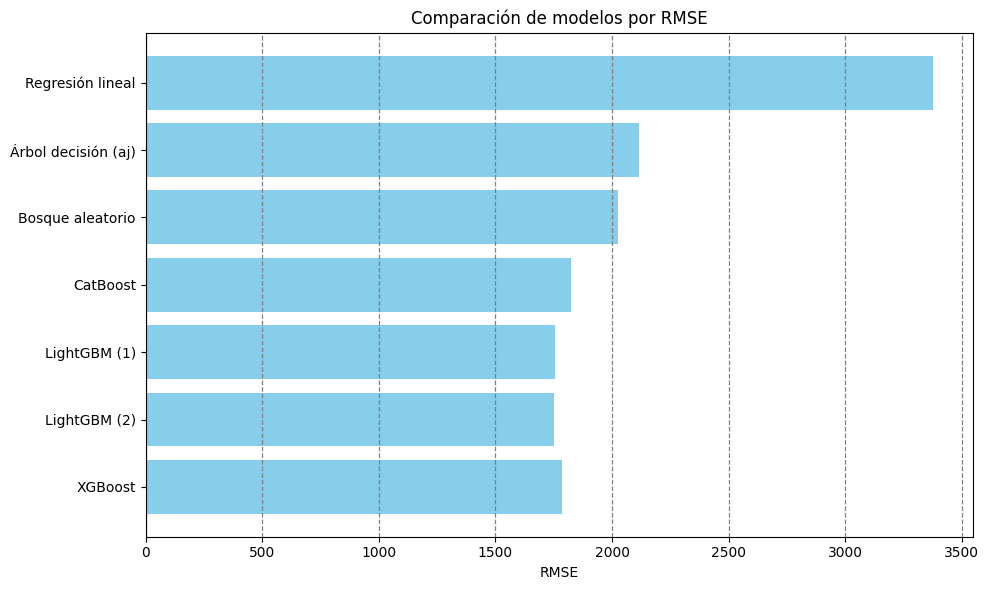

In [44]:
# Lista de modelos y sus RMSE
modelos = [
    "Regresión lineal",
    "Árbol decisión (aj)",
    "Bosque aleatorio",
    "CatBoost",
    "LightGBM (1)",
    "LightGBM (2)",
    "XGBoost"
]

rmse_valores = [
    3376.94,
    2117.12,
    2027.14,
    1823.15,
    1754.40,
    1753.04,
    1787.56
]

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(modelos, rmse_valores, color='skyblue')
plt.xlabel("RMSE")
plt.title("Comparación de modelos por RMSE")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.grid(color='gray', linestyle='--', linewidth=0.9, axis='x', which='both')
plt.show()

## Analisis de resultados

Los mejores resultados en cuanto a RMSE fueron obtenidos con LightGBM (set 2) y LightGBM (set 1), con valores de ≈1753 y ≈1754, respectivamente. CatBoost y XGBoost también lograron buenos resultados, con RMSE menores a 1850. LightGBM destacó además por su balance entre velocidad y precisión.

La regresión lineal, como se esperaba, fue la más rápida, pero mostró un RMSE muy alto, lo que la hace poco útil para este caso práctico. El árbol de decisión ajustado y el bosque aleatorio mejoraron significativamente la precisión, aunque a costa de mayor tiempo de entrenamiento.

## Conclusiones

- **Sí es posible construir un modelo que prediga con buena precisión el valor de mercado de un coche usado.**
- Se recomienda utilizar LightGBM con ajuste de hiperparámetros por su precisión, rapidez y compatibilidad con producción.
- También se destaca CatBoost por su facilidad de uso con variables categóricas y velocidad competitiva.